In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import chaospy
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

# Sampling a 16-d funnel

In [2]:
D = 16 # number of dims
a = 1.
b = 0.5
lower = np.full(D, -10.) # lower bound of the prior for x_1, ...
upper = np.full(D, 10.) # upper bound of the prior for x_1, ...
lower[0] = -5 # lower bound of the prior for x_0
upper[0] = 5 # upper bound of the prior for x_0
bound = np.array((lower, upper)).T
diff = bound[:, 1] - bound[:, 0]
const = np.sum(np.log(diff)) # normalization of the flat prior

def log_like(x):
    _a = jax.scipy.stats.norm.logpdf(x[0], loc=0, scale=a)
    _b = jnp.sum(jax.scipy.stats.norm.logpdf(x[1:], loc=0, scale=jnp.exp(b * x[..., 0])))
    return _a + _b

def log_flat_prior(x):
    return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc=lower, scale=upper-lower))

log_like_grad = jax.grad(log_like)
log_prior_grad = jax.grad(log_flat_prior)

jax_prior_init = jax.random.uniform(key, shape=(300, D), minval=lower, maxval=upper)
print(jnp.amax(jax_prior_init[:, 5]))
print(jnp.amin(jax_prior_init[:, 5]))

x_prime = np.random.normal(0, 1, size=(1000, D))
x_prime[:, 0] = x_prime[:, 0] * a
x_prime[:, 1:] = x_prime[:, 1:] * np.exp(b * x_prime[:, 0]).reshape((1000, 1))

9.865362
-9.962805


Below I have defined the key parameters that I think you will need to worry about. If you look at the actual code you'll see a lot more parameters. Some of these are from older versions of the algorithm, and some of these are only relevant for the NFO optimization algorithm. We'll tidy this up at some point, but this should be enough to get you going.

In [3]:
'''
General parameters
------------------
In addition to the log-likelihood and prior functions defined above that you'll pass, we have:

1. log_like_args: Any additional arguments to be passed to the log-likelihood function as a tuple object.
2. log_prior_args: As above but for the prior. Not necessary here, but I've included arguments for illustration.
3. inference_mode: Either 'optimization' or 'sampling'. You'll want 'sampling'.
4. vmap: If True we evaluate the log-likelihood and prior functions using a vectorizing map (i.e. jax.vmap). 
   If False we parallelise the computation over available cores. The parallelisation has been tested on NERSC, 
   but I've pretty much exclusively been using vmap (you may want to parallelise if you have some very expensive 
   likelihoods).
5. parallel_backend: If using parallel evaluations, choose the parallel backend. Can be set to Pool, Client or
   MapReduce. Will use multiprocess, dask or sharedmem respectively. If left as None, will use multiprocess.
6. bounds: Any hard parameter bounds to pass to SINF/SNF. Passed as array([lower_bounds, upper_bounds]). None
   if no hard bounds.
7. k_trunc: Clipping parameter for importance weights. IW clipped at <IW>*N^k_trunc. Note, not currently used
   with SMC-type sampling.
8. random_seed: Random seed for inference.
'''
log_like_args = ()
log_prior_args = () 
inference_mode = 'DLA'
vmap = True
parallel_backend = None
bounds = np.array([lower, upper])
k_trunc = 0.5
random_seed = seed
init_logq = None

'''
SINF/SNF parameters
---------------
Key SINF/SNF parameters. See GIS.py, SINF.py and optimize.py for code.

1. alpha_w: Regularisation parameters for weighted q SINF fits. Passed as a tuple of two values between 0 and 1. 
   Closer to 1 will give more regularisation. If set to None, SINF uses cross-validation to choose a value.
2. NBfirstlayer: Whether to use a Naive Bayes first layer in SINF.
3. verbose: Whether you want verbose output from SINF.
4. interp_nbin: Number of spline knots for rational quadratic splines in SINF. 
5. trainable_qw: Whether to run SNF after SINF. This was relevant when SINF and SNF were contained in the same
   method. There are separate methods now, and I'm using this so I can more easily change things. You should
   probably leave this as False for now. It won't break anything if you set it as True. Just means you'll run 
   SNF one more time than you think.
6. sgd_steps: Number of stochastic gradient descent steps to take for SNF training.
7. gamma: Parameter in loss function 1 (log E(q^(-gamma)*(p - Zq)^2)). 
8. knots_trainable: Only relevant if trainable_qw is True, in which case this overwrites interp_nbin.
9. optimize_directions: Whether we optimize directions in SNF.
10. logp_cut: logp threshold to be applied during SNF training. Currently I don't impose a cut.
11. edge_bins: Number of spline knots at the boundary.
12. Whiten: Whether to include a whitening layer for SINF.
13. iteration: Maximum number of SINF layers.
14. NERCOME: Whether to use the NERCOME algorithm for SINF.
'''
#sinf parameters
alpha_w = (0.0, 0.9)
NBfirstlayer = True
verbose = False
interp_nbin = 10
trainable_qw = False # Just leave this for now.
sgd_steps = 100
gamma = 0
knots_trainable = 10
optimize_directions = False
logp_cut = None
edge_bins = 0
Whiten = True
Whiten_with_weights = True
iteration = 20
NERCOME = True
t_ess = 0.9

'''
SMC parameters
--------------
Parameters used for SMC and MH exploration strategies.

1. nfmc_frac_validate: Fraction of samples used in validation for SINF/SNF.
2. min_delta_beta_init: Minimum relative change in beta at start.
3. min_delta_beta_final: Minimum relative change in beta at end. delta_beta decays to this between start and end.
4. snf_loss: Specify the SNF loss function. (0) E(q^(-gamma)*(p - Zq)^2), (1) log E(q^(-gamma)*(p - Zq)^2),
   (2) sum((logp-logq-logZ)^2), (3) -E(logq), (4) log(E((q/q_uw)(p/q - Z)^2)).
5. nfmc_snf_only: Whether to only use trainable SNF updates to q after the first q fit.
6. fixed_beta_schedule: Can specify a fixed beta schedule as a list of beta values.
7. vanilla_smc: Whether to use the SMC+MH exploration strategy. This is currently the focus for sampling.
   Old option was to intialise using NFO optimization.
8. reg: SNF regularisation parameter.
9. reg1: SNF regularisation parameter.
10. mh_mode: Specify 'IMH' for independent MH exploration, 'CMH' for latent space MH, 'both' for using both.
    CMH is still being tested so stick with 'IMH' for now.
11. imh_target_acc_rate: Target acceptance fraction for original samples in IMH.
12. max_imh_steps: Maximum number of IMH iterations at a given temperature level.
13. cmh_target_acc_rate: Target acceptance rate for CMH exploration.
14. max_cmh_steps: Maximum number of steps in a CMH chain.
15. cmh_p_acc_rate: Parameter used for tuning number of CMH steps. Between 0 and 1. Closer to 1 results in more
    steps.
16. sinf_resampled: Whether to fit SINF using re-sampled samples and uniform weight.
'''
nfmc_frac_validate = 0.1
frac_validate = 0.1
min_delta_beta_init = 0.01
min_delta_beta_final = 0.01
snf_loss = 3
nfmc_snf_only = False
fixed_beta_schedule = None
vanilla_smc = True
reg = 0.0
reg1 = 1.0
reg2 = 1.0
latent_mcmc = 'LIMH'
imh_target_acc_rate = 0.5
max_imh_steps = 25
cmh_target_acc_rate = 0.234
max_cmh_steps = 25
cmh_p_acc_rate = 0.85
sinf_resampled = True
fixed_beta_updates = 'LIMH'
nf_iter = 25
slice_iterations = 10

dla_step_size = 1.0
num_extra_dla_samples = 0
grad_norm_thresh = 0.5
max_dla_line_steps = 20
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
eps_z = 0.1
accelerate_dla = True
grad_free_dla = False
dla_beta_thresh = 0.5
latent_dla = True
rel_fish_tol = 1e-3
abs_fish_tol = 1e-3


Now we can run our 10d Gaussian example.

In [4]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_flat_prior, 
                             init_samples=jax_prior_init, 
                             log_prior_args=log_prior_args,
                             init_logq=None,
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             frac_validate=frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=NERCOME,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             eps_z=eps_z,
                             accelerate_dla=accelerate_dla,
                             grad_free_dla=grad_free_dla,
                             dla_beta_thresh=dla_beta_thresh,
                             latent_dla=latent_dla,
                             rel_fish_tol=rel_fish_tol,
                             abs_fish_tol=abs_fish_tol)

Inference mode is DLA. Maximum beta is set to 1.


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:2122: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  nf_model = GIS(torch.from_numpy(np.asarray(samples[fit_idx, ...])),
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:344: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg

Time for SINF fit = 1.618423914000001
Time for SNF training = 18.873595811
Current logZ estimate = -52.33428192138672
DLA acceleration beta = 0.0001220703125
Time for SINF fit = 0.6074045060000017
Time for SNF training = 18.138360861
Mean number of latent DLA line search iterations: 1.2
Time for latent space DLA = 7.462406799999997
Acceptance rate for latent MH adjustment: 0.19666666666666666
Time for latent MH DLA adjustment = 2.2612270349999974
Time for SINF fit = 0.5624937239999994
Time for SNF training = 18.197731067000007
Current logZ estimate = -50.60470199584961
Burnin stage 1, Fisher Divergence: 419439.5625
Burnin stage 1, abs(norm(dlogq)/norm(dlogp)) = 0.1835784614086151
DLA acceleration beta = 0.0224609375
Time for SINF fit = 0.590190578000005
Time for SNF training = 18.755842763000004
Mean number of latent DLA line search iterations: 1.97
Time for latent space DLA = 6.593387758000006
Acceptance rate for latent MH adjustment: 0.17333333333333334
Time for latent MH DLA adjustm

Time for SINF fit = 1.9376555640000106
Time for SNF training = 22.366082667
Mean number of latent DLA line search iterations: 2.81
Time for latent space DLA = 12.800876308999932
Acceptance rate for latent MH adjustment: 0.09
Time for latent MH DLA adjustment = 0.6845242120000421
Time for SINF fit = 1.8766326039999512
Time for SNF training = 21.754085626999995
Current logZ estimate = -22.51076889038086
DLA stage 15, Latent Fisher Divergence: 116.64993286132812
DLA acceleration beta = 0.05078125
Time for SINF fit = 1.8430909029999611
Time for SNF training = 21.331065051999985
Mean number of latent DLA line search iterations: 2.11
Time for latent space DLA = 13.993053215999907
Acceptance rate for latent MH adjustment: 0.05333333333333334
Time for latent MH DLA adjustment = 0.22753216299997803
Time for SINF fit = 2.199292602000014
Time for SNF training = 22.250413678000086
Current logZ estimate = -25.191265106201172
DLA stage 16, Latent Fisher Divergence: 103.71987915039062
DLA acceleratio

The output from sampling is stored in the trace object. This is currently a collection of dictionaries containing a lot of output stats and samples for development/debugging purposes.

In [5]:
44.93142318725586# Check the dictionary keys.
trace.keys()

dict_keys(['final_q_samples', 'final_qw_weights', 'log_evidence', 'mh_samples', 'dla_samples', 'mh_logp', 'mh_logq', 'mh_dlogp', 'mh_dlogq', 'dla_logZ', 'dla_qmodels'])

In [6]:
# To inspect the sampling output, we can pull out the q_models.
q_models = trace['dla_qmodels'][0]
q_models.keys()
#print(len(q_models.keys()))

dict_keys(['burnin_0', 'burnin_1', 'post_burnin_0', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'DLA_11', 'DLA_12', 'DLA_13', 'DLA_14', 'DLA_15', 'DLA_16', 'DLA_17', 'DLA_18', 'DLA_19', 'DLA_20', 'DLA_21'])

In [7]:
q_string = 'DLA_21'

# There were 10 temperature levels. q10_w corresponds to the q fit at beta=1 i.e. the target.
qi = q_models[q_string]
q_samples, logq = qi.sample(2000, device='cpu')
q_samples, logq = q_samples.numpy(), logq.numpy()
iw = jax.vmap(lambda x: log_like(x))(q_samples)
logp = jax.vmap(lambda x: log_like(x))(q_samples)
logw = logp - logq
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

#q_samples = trace['final_qw_samples'][0]
#iw = trace['final_qw_weights'][0]
#beta = trace['betas'][0][-1]
#print(f'beta = {beta}')
beta = 1

x_prime = np.random.normal(0, 1, size=(1000, D))
x_prime[:, 0] = x_prime[:, 0] * a / np.sqrt(beta)
x_prime[:, 1:] = x_prime[:, 1:] * np.exp(b * x_prime[:, 0]).reshape((1000, 1)) / np.sqrt(beta)

In [8]:
def plot_triangles(samples, weights, truth_samples, Ngd=1000, beta_idx=None,
                   out_name=None, d=16):

    names = ["x%s"%i for i in range(d)]
    labels =  ["x_%s"%i for i in range(d)]

    truth = MCSamples(samples=truth_samples, names=names,
                      labels=labels, label='Ground Truth')
    samples_w = MCSamples(samples=samples, weights=weights,
                          names=names, labels=labels, 
                          label='posterior samples')

    # Triangle plot
    plt.figure()
    g = plots.get_subplot_plotter()
    g.triangle_plot([truth, samples_w], filled=True)
    plt.show()
    if out_name is not None:
        g.export(out_name)

# Whiten=True, Whiten_with_weights=False, NERCOME=True

Don't have any no parameters in SNF errors. Final result has similar issue to vanilla SMC for funnel. Can be improved with repeated beta=1 fits.

Got the damn samples


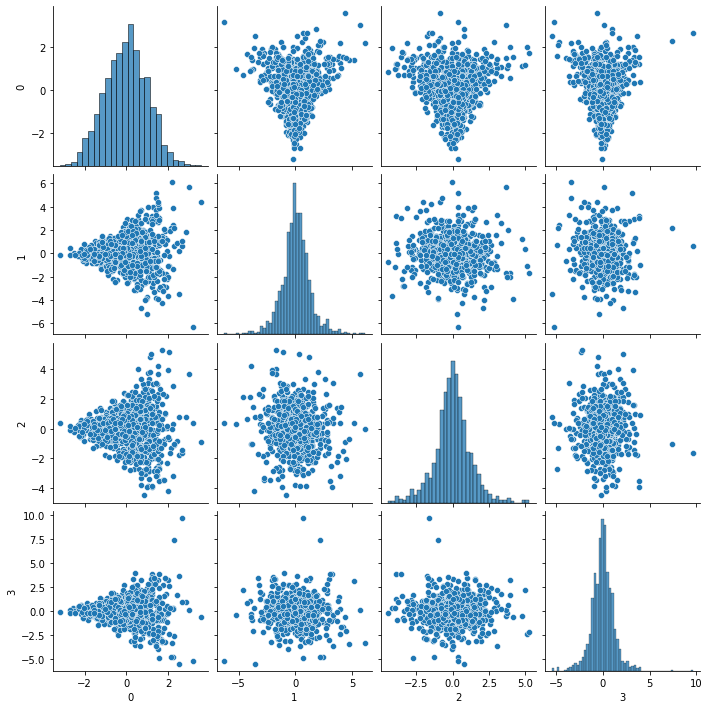

In [9]:
#beta = 1.0

x_prime = np.random.normal(0, 1, size=(1000, D))
x_prime[:, 0] = x_prime[:, 0] * a / np.sqrt(beta)
x_prime[:, 1:] = x_prime[:, 1:] * np.exp(b * x_prime[:, 0]).reshape((1000, 1)) / np.sqrt(beta)

print(f'Got the damn samples')

df = pd.DataFrame(x_prime[:, 0:4])
sns.pairplot(df)

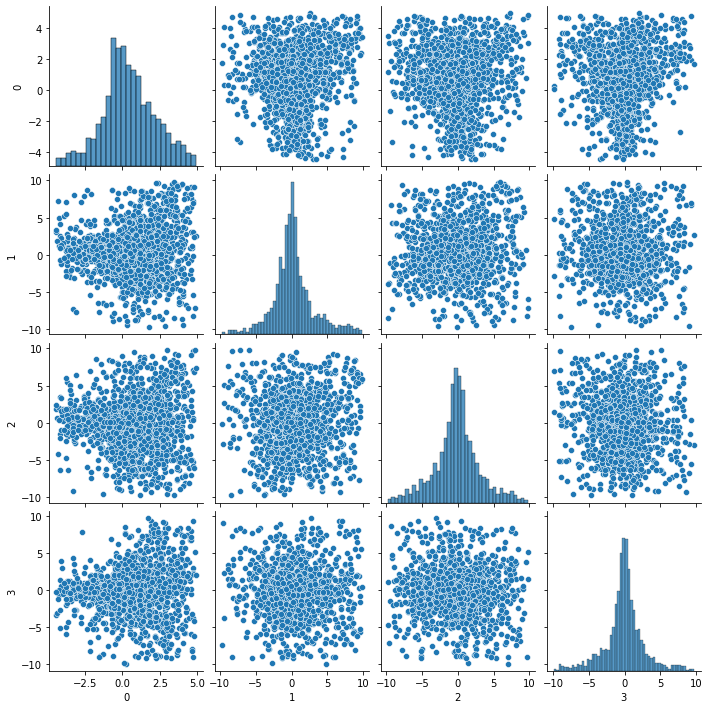

In [10]:
df = pd.DataFrame(q_samples[:, 0:4])
sns.pairplot(df)

Removed no burn in
Removed no burn in


<Figure size 432x288 with 0 Axes>

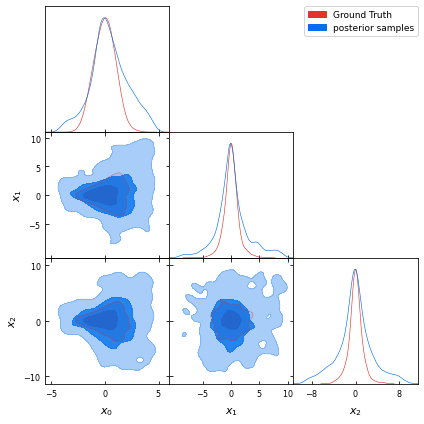

In [11]:
# First plot the samples without weights.
plot_triangles(q_samples[:,0:3], np.ones(len(q_samples)), truth_samples=x_prime[:,0:3], 
               out_name='funnel_noweight_DLA_grad.png', d=3)

Removed no burn in
Removed no burn in


<Figure size 432x288 with 0 Axes>

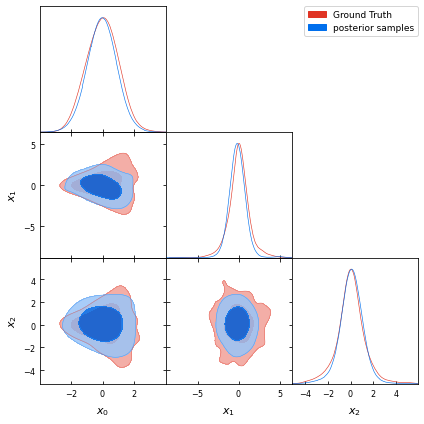

In [12]:
plot_triangles(q_samples[:,0:3], iw, truth_samples=x_prime[:,0:3], out_name='funnel_weight_CMH_loss3.png', 
               d=3)

In [13]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

     labels     $x_0$     $x_1$     $x_2$     $x_3$
0         q -0.714106  0.528917  6.295696 -0.330759
1         q  0.199052  0.517166 -0.803484  0.027586
2         q  1.828605 -3.961459 -1.584371  4.264656
3         q -2.309513  0.459576  0.837290 -0.756446
4         q -1.506543 -1.351893  1.123027  0.743889
...     ...       ...       ...       ...       ...
2995      T  0.274625 -0.974808 -1.086503 -0.315590
2996      T -0.299825 -0.297796  0.405888 -1.050680
2997      T -0.045425 -0.718451 -0.508127 -0.371226
2998      T  0.139166 -0.114201 -1.857013  0.405863
2999      T -1.563651 -0.053080  0.128266 -0.263926

[3000 rows x 5 columns]


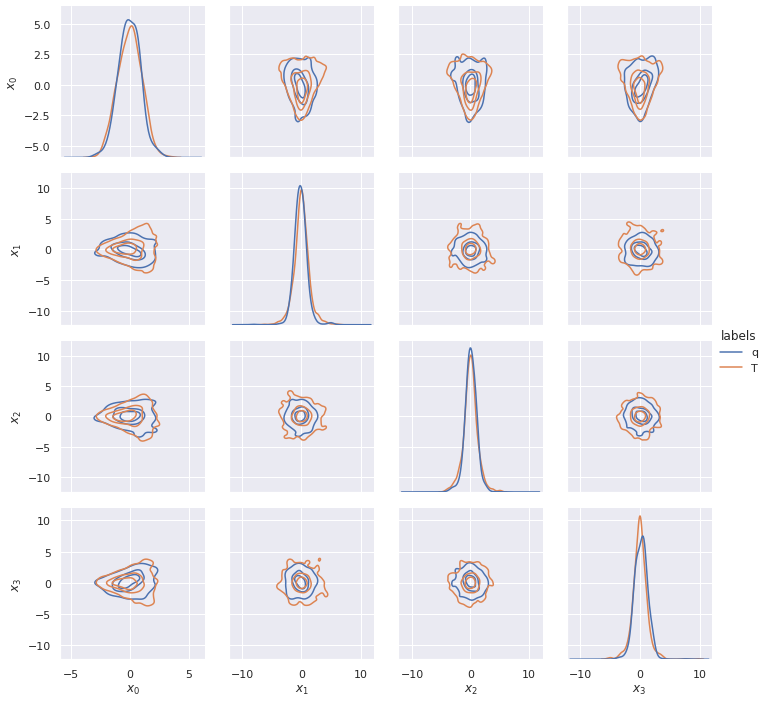

In [14]:
sns_pairplot(q_samples[:, 0:4], iw, x_prime[:, 0:4], levels=4, 
             out_name='./dla_figs/funnel_16d_final_weighted.png')

     labels     $x_0$     $x_1$     $x_2$     $x_3$
0         q -2.743546  0.357971  2.562327 -1.236784
1         q  3.182696 -2.248374  0.612011  1.967439
2         q  1.032429  0.056826 -0.266038 -1.501257
3         q  1.314948  4.304429  2.630910  1.852251
4         q  0.646222  4.774312  1.368743  0.811416
...     ...       ...       ...       ...       ...
2295      T  0.200663 -0.495774  1.286656 -0.212917
2296      T -0.358535  0.437187  0.453195  1.047625
2297      T -0.025528 -0.721077  1.711824  1.125372
2298      T  0.727651 -0.417952  1.464705 -2.825271
2299      T  0.143559  0.682592  0.017291 -1.370391

[2300 rows x 5 columns]


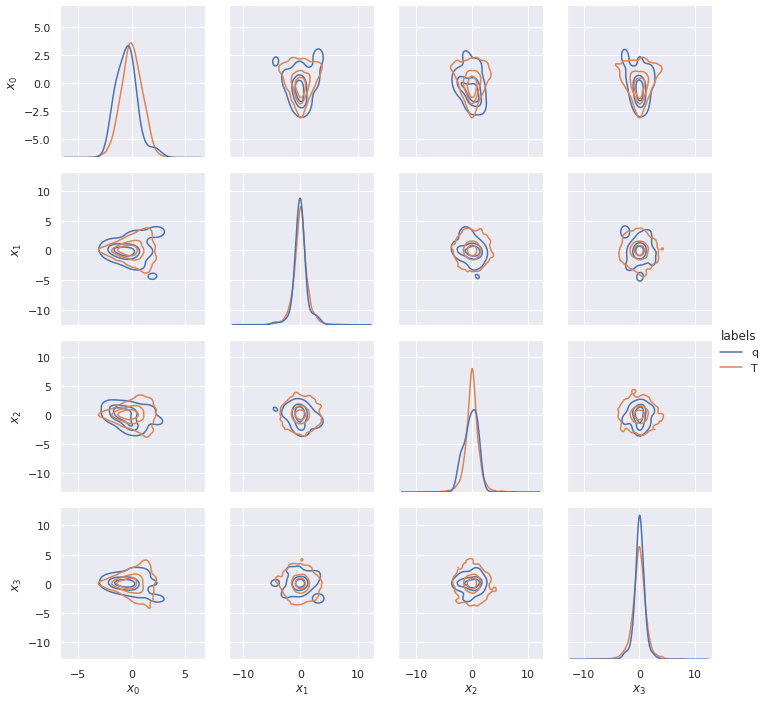

In [17]:
beta = 1

x_prime = np.random.normal(0, 1, size=(2000, D))
x_prime[:, 0] = x_prime[:, 0] * a / np.sqrt(beta)
x_prime[:, 1:] = x_prime[:, 1:] * np.exp(b * x_prime[:, 0]).reshape((2000, 1)) / np.sqrt(beta)

#for key in list(q_models.keys()):
for key in ['DLA_21']:

    # There were 10 temperature levels. q10_w corresponds to the q fit at beta=1 i.e. the target.
    qi = q_models[key]
    q_samples, logq = qi.sample(300, device='cpu')
    q_samples, logq = q_samples.numpy(), logq.numpy()
    iw = jax.vmap(lambda x: log_like(x))(q_samples)
    logp = jax.vmap(lambda x: log_like(x))(q_samples)
    logw = logp - logq
    logw -= logsumexp(logw)
    iw = np.exp(logw)
    iw /= np.sum(iw)
    
    sns_pairplot(q_samples[:, 0:4], iw, x_prime[:, 0:4], levels=4, 
                 out_name=f'./dla_figs/funnel_16d_{key}_20layers.png')